In [59]:
library(scDDboost)
library(Seurat)
library(vcd)

In [2]:
## first check GSE74596

load("~/empirical_data/GSE74596.RData")

In [3]:
table(cd)

cd
 1  2 
46 68 

In [9]:
detK(D_c)

[1] 7

In [20]:
listsize(newPDD)

[1] 3521

In [17]:
length(which(res_des$padj < 0.05))

[1] 2561

In [22]:
ccl = pam(D_c,diss = T, k = 7, cluster.only = T)

In [41]:
table(pam(D_c,diss = T, k = 6, cluster.only = T))


 1  2  3  4  5  6 
20 25 25 15 15 14 

In [24]:
table(ccl)

ccl
 1  2  3  4  5  6  7 
20 24 25 15 15 14  1 

In [25]:
which(ccl == 7)

GSM1923623_NKT2High_SCT9_N0517_N0710_W32_MappedReads_Annotations.txt 
                                                                  90

In [28]:
totalCounts = colSums(data_counts)

In [30]:
totalCounts[90]

GSM1923623_NKT2High_SCT9_N0517_N0710_W32_MappedReads_Annotations.txt 
                                                             5316375

In [34]:
totalCounts[89]

GSM1923622_NKT2High_SCT9_N0508_N0712_W47_MappedReads_Annotations.txt 
                                                             3832223

In [38]:
obs <- CreateSeuratObject(data_counts, project = "obs")

Idents(obs) <- ccl

obs <- NormalizeData(obs)

obs <- FindVariableFeatures(obs)

obs <- ScaleData(obs)

obs <- RunPCA(obs, pc.genes = obs@var.genes, do.print = FALSE,  pcs.compute = 50)

Centering and scaling data matrix
PC_ 1 
Positive:  Stmn1, 2810417H13Rik, Birc5, Tuba1b, Top2a, Kpna2, Cdk1, Cdca8, Prc1, Tacc3 
	   Plk1, Cks1b, Tk1, Ccnb1, Ncaph, Hmgb2, Rrm1, Spc25, Smc2, Rrm2 
	   Cdca3, Nusap1, Asf1b, H2afz, Ube2c, Pbk, Ccna2, Tyms, Prim1, Ckap2l 
Negative:  Nkg7, AW112010, Malat1, H2-K1, Klrb1c, Cd7, Id2, Rn45s, Klrd1, Ms4a4b 
	   Gimap3, Xcl1, Ly6c2, Lpar6, Btg1, Klrk1, Gzmb, Fasl, Slamf7, Ifngr1 
	   Rgs1, Gimap6, Stat4, Hsd11b1, Cxcr3, Il2rb, Fcer1g, Fgl2, Lrrk1, Pglyrp1 
PC_ 2 
Positive:  Asf1b, Rrm2, Spc25, Prc1, Ccna2, Nusap1, Birc5, 2810417H13Rik, Esco2, Cdk1 
	   Hist1h1b, Top2a, Kif20a, Cdca3, Mis18bp1, Pbk, Kif22, Plk1, Ckap2l, Tk1 
	   Aurkb, Cdca5, Tyms, Cdca8, Kif11, Smc2, Ncaph, Ndc80, Ube2c, Aurka 
Negative:  Tox, Supt3h, Zbtb48, Nucb2, Sox4, Msra, Nt5e, 2310037I24Rik, Tcn2, Vwa5a 
	   Nsun2, Erap1, Myo1e, C330006K01Rik, Derl3, Matk, Pdcd1, Bod1, Cntnap1, Tnip2 
	   Ptpn7, Mll2, 0610007L01Rik, Uba7, Trim36, Thumpd1, Sec16a, Gadl1, Plac8, Crat 
PC_ 

In [39]:
obs <- RunUMAP(obs,dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”10:59:57 UMAP embedding parameters a = 0.9922 b = 1.112
10:59:57 Read 114 rows and found 10 numeric columns
10:59:57 Using Annoy for neighbor search, n_neighbors = 30
10:59:57 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
10:59:58 Writing NN index file to temp file /tmp/RtmpoSeu6I/file1aa6a3395d9d65
10:59:58 Searching Annoy index using 1 thread, search_k = 3000
10:59:58 Annoy recall = 100%
10:59:59 Commencing smooth kNN distance calibration using 1 thread
11:00:00 Initializing from normalized Laplacian + noise
11:00:00 Commencing optimizati

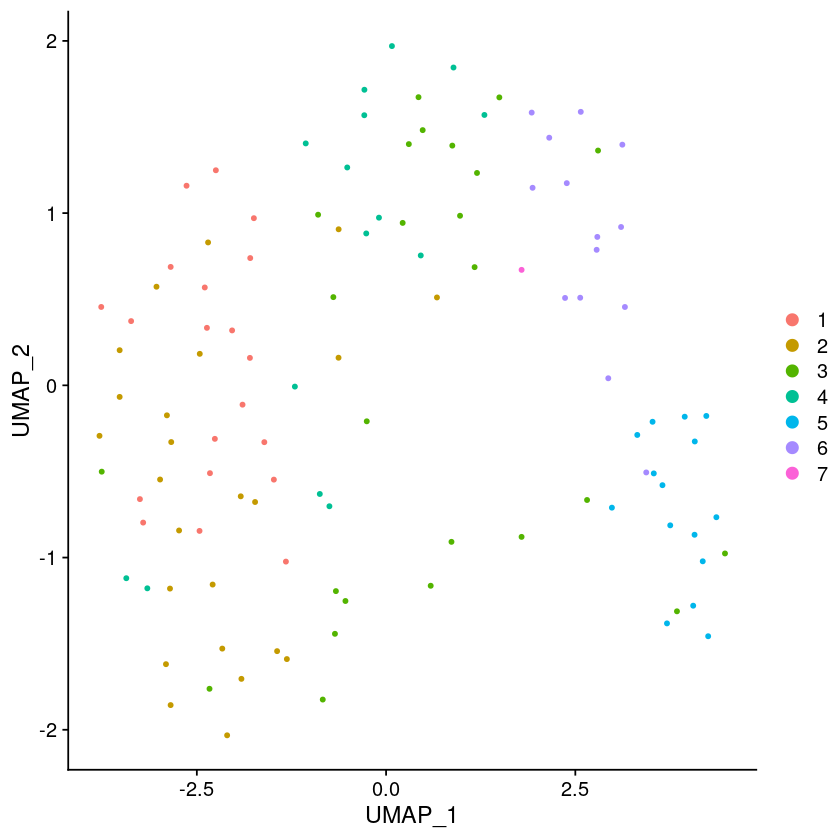

In [40]:
DimPlot(obs, reduction = "umap")

In [45]:
Means = list()

for(i in 1:6){
    tmp = which(ccl == i)
    Means[[i]] = rowMeans(data_counts[,tmp])
}


In [46]:
SingleGroup = data_counts[,which(ccl == 7)]

In [182]:
tmp = Group[2,]

### bin 0,1,2,3,4 and >= 5

LogL <- function(param,x){
    res = 0
    r = param[1]
    p = param[2]
    for(i in 1:5){
        res = res + log(dnbinom(i - 1,size = r, prob = p)) * x[i]
    }
    res = res  + log( 1 - pnbinom(4,size = r, prob = p)) * x[6]
    
    return(-res)
}

gof <- function(X){
obs = rep(NA,6)
for(i in 1:5){
    obs[i] = length(which(X == (i - 1)))
}
obs[6] = length(which(X >=5))

fit = nlminb(start(1,0.1),objective = LogL,x = obs, lower = c(0.01,0.01), upper = c(1000,0.99))

r = fit$par[1]
p = fit$par[2]

exp = rep(NA,6)
nc = sum(obs)
for(i in 1:5){
    exp[i] = dnbinom(i - 1,size = r, prob = p) * nc
}
exp[6] = (1 - pnbinom(4,size = r, prob = p)) * nc


CHI = sum((obs - exp)^2 / exp)

df = nc - 2

    result = list()
    result$r = r
    result$p = p
    result$pv = 1- pchisq(CHI,df = df)
return(result)
    
    }

In [183]:
R = list()

In [213]:
ii = 1
Group = data_counts[,which(ccl == ii)] 

G = nrow(Group)

nc = ncol(Group)

pv = rep(NA,G)

tmpr = rep(NA,G)

for(i in 1:G){
    tmp = Group[i,]
    m = mean(tmp)
    
    if(m > 0.001){
        tmpr[i] = gof(tmp)$r
    }
}

R[[ii]] = tmpr

In [214]:
r1 = R[[1]]
r2 = R[[2]]

valid = intersect(which(!is.na(r1)), which(!is.na(r2)))

In [221]:
diff = 1 - r1[valid] / r2[valid]


In [224]:
length(which(abs(diff) > 5))

[1] 1340

In [225]:
length(which(abs(diff) <= 5))

[1] 7808

In [222]:
quantile(diff)

0%           25%           50%           75%          100% 
-1.988983e+03 -1.615680e+00 -7.402562e-02  5.055002e-01  9.997269e-01

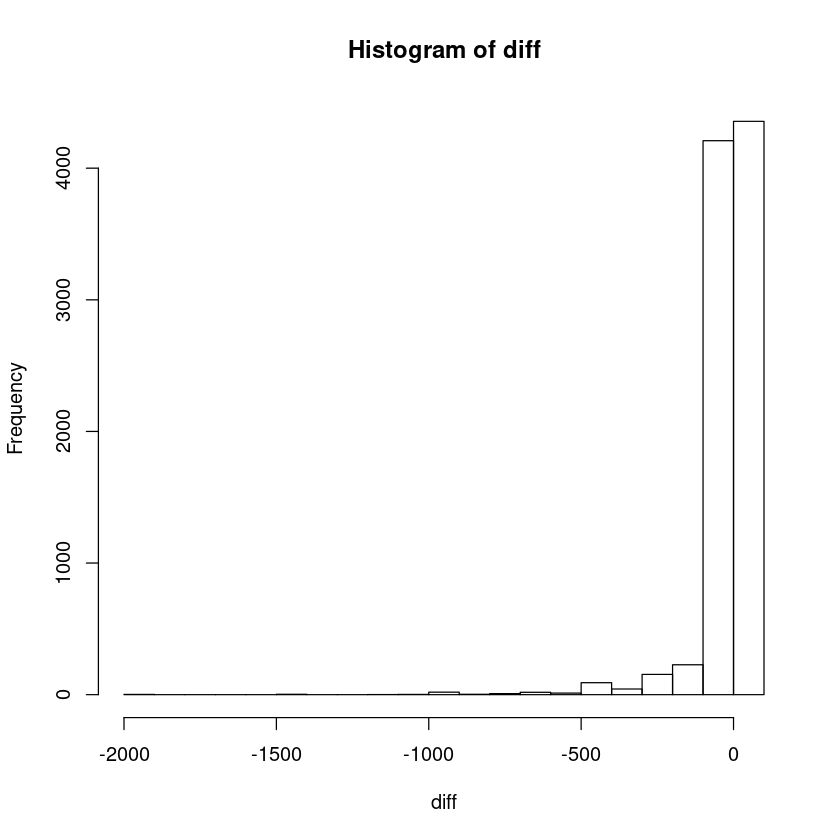

In [223]:
hist(diff)